## CIP-50 Leverage-based Pool Ranking Analysis
CCGarant, 8/21/22, @TheStophe

Supporting work for the CIP-50 leveraged-base pool ranking system, comparing Daedalus ranking to CIP-50 Ranking.

## Leverage-based Pool Ranking Recommendation

Pool ranking scores in wallet browsers have a significant and powerful game theory impact on delegator pool choices, yet it is often overlooked and not transparent in wallets.

When pledge becomes the most important factor for total pool size, lower leverage factors are more desirable. Lists should be sorted by leverage and presented in an descending order with the lowest leverage pools first.

### Ranking Equation

The recommended ranking equation starts with the highest score of 10. The pools are down-ranked solely based on leverage, saturation, and fee factors.

    //equation
    ranking_score = 10 - max{ leverage_factor, saturation_factor } - fee_factor

    //variables
    leverage_factor = 10 * (pool_leverage/L)^A
    saturation_factor = 2 * (pool_stake/(saturation_stake * C))^B
    fee_factor = D * pool_fee_margin

    //parameters
    - A is 2.0, has range (0,10.0), can be tweaked
    - B is 5.0, has range (0,10.0), can be tweaked
    - C is 0.9, has range (0,2.0), can be tweaked
    - D is 50, has range (0-100) ish to be harsh, can be tweaked
    - pool_leverage = delegation / pledge
    - pool_stake = pledge + delegation
    - saturation_stake = total_live_stake/k (e.g. 68M₳ "soft-cap upper limit")
    - pool_fee_margin is in range (0-100)% (fixed fee + margin combined)

To evaluate rank using the current reward scheme:

    //current reward scheme only
    ranking_score = 10 - max{ leverage_factor , saturation_factor } - fee_factor - fixed_fee_factor

    //variables
    //if fee = minFee, term drops out
    //if fee > minFee, term nonzero but loses relevance w/ increased stake
    //fixed fee matters less to rewards as stake grows, so too here
    fixed_fee_factor = E * (fee-minFee) / stake 

    //parameters
    - E is 100, has range (0,100_000), can be tweaked
    - fee cannot be less than minFee

In [1]:
#imports
import numpy as np
import pandas as pd
import bokeh as bk
import matplotlib.pyplot as plt

### Power Curves Refresher
A few examples of power curves and the effects of the exponent

Text(0.5, 1.0, 'Power Curve Squared y=x^2')

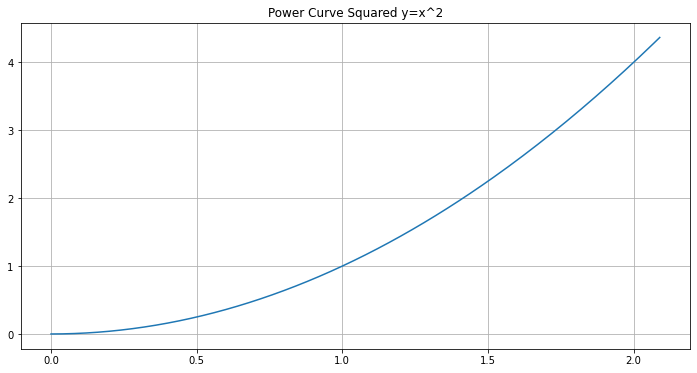

In [57]:
x = np.arange(0,2.1,.01)
y = np.power(x,2)
f = plt.figure(figsize=(12,6))
plt.plot(x,y)
plt.grid('on')
plt.title('Power Curve Squared y=x^2')

[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25
 3.5  3.75 4.  ]


Text(0.5, 1.0, 'Power Curve y=x^A with A from 0 to 4.25 by 0.25')

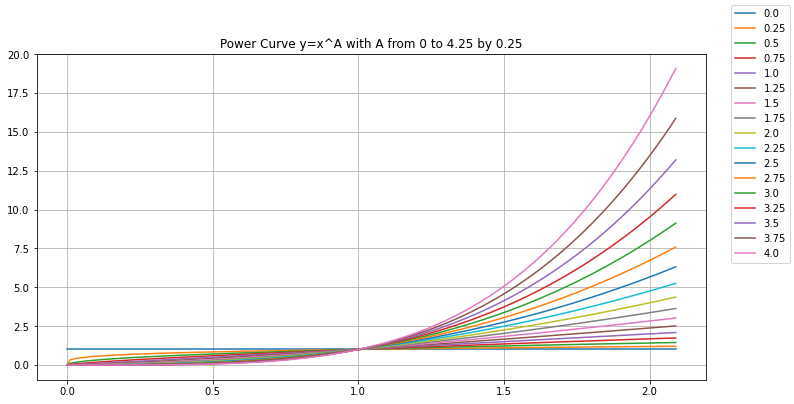

In [58]:
f = plt.figure(figsize=(12,6))
r = np.arange(0,4.25,.25)
print(r)

for r0 in r:
    y = np.power(x,r0)
    plt.plot(x,y)
plt.grid('on')
f.legend(r)
plt.title('Power Curve y=x^A with A from 0 to 4.25 by 0.25')


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


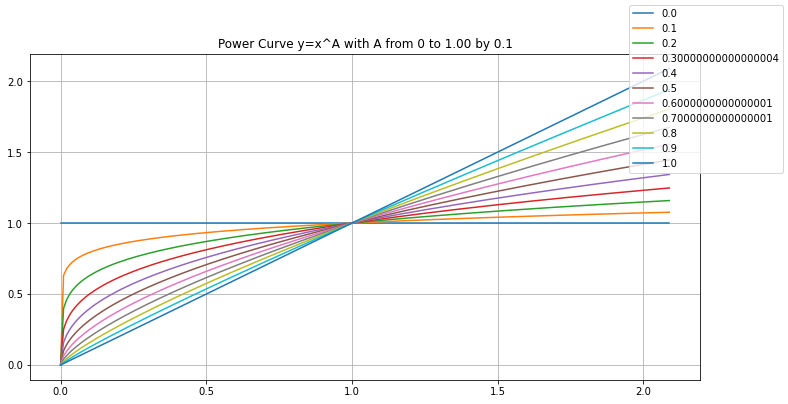

In [68]:
f = plt.figure(figsize=(12,6))
r = np.arange(0,1.1,.1)
print(r)

for r0 in r:
    y = np.power(x,r0)
    plt.plot(x,y)
plt.grid('on')
plt.title('Power Curve y=x^A with A from 0 to 1.00 by 0.1')
f.legend(r)


## Ranking Equations
The following ranking equations will be explored:
- CIP-50 Leverage-Based
- Daedalus
- Eternl

### Leverage-Based Ranking Equation



In [94]:
#parameters

A = 2.0
B = 5.0
C = 0.9
D = 50
E = 100
L = 100
minFee = 340 #[Ada]
k = 500
# a0

In [91]:
#functions

def leverage_factor(poolLeverage,L,A):
    return 10*np.power(poolLeverage/L,A)

def saturation_factor(poolStake,saturationStake,B,C):
    return 2*np.power((poolStake/(saturationStake*C)),B)

def fee_factor(poolFeeMargin,D):
    return poolFeeMargin*D

def fixed_fee_factor(fee,minFee,stake,E):
    return E*(fee-minFee)/stake

def ranking_equation(leverage_factor,saturation_factor,fee_factor,fixed_fee_factor):
    return 10-np.max([leverage_factor,saturation_factor])-fee_factor-fixed_fee_factor


In [93]:
#checks, using SKY from spreadsheet as a reference

## SKY POOL
pledge = 123
stake = 6_080
fee = 340
margin = 0.01 #[1.0%]


lf =leverage_factor(49.4,L,A) #correct
sf = saturation_factor(6_203,68_555_404,B,C) #correct
ff = fee_factor(margin,D)
fff = fixed_fee_factor(fee,minFee,stake,E)
rank = ranking_equation(lf,sf,ff,fff)
rank_round_up = np.ceil(rank)

print(f'leverage_factor: {lf}')
print(f'saturation_factor: {sf}')
print(f'fee_factor: {ff}')
print(f'fixed_fee_factor: {fff}')
print(f'rank: {rank}')
print(f'rank_round_up: {rank_round_up}')

# matches spreadsheet ::check::

leverage_factor: 2.44036
saturation_factor: 2.0540824962918913e-20
fee_factor: 0.5
fixed_fee_factor: 0.0
rank: 7.05964
rank_round_up: 8.0


4